### License
> Copyright 2023 Anna Maria Krol
>
> Licensed under the Apache License, Version 2.0 (the "License");
> you may not use this file except in compliance with the License.
> You may obtain a copy of the License at
>
>     http://www.apache.org/licenses/LICENSE-2.0
>
> Unless required by applicable law or agreed to in writing, software
> distributed under the License is distributed on an "AS IS" BASIS,
> WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
> See the License for the specific language governing permissions and
> limitations under the License.

In [1]:
# python 3.9.18 kernel with Qiskit
import matplotlib.pyplot as plt
import numpy as np
from qiskit_aer import AerSimulator
# for use with older versions of Qiskit/Qiskit Aer
from qiskit import Aer
from qiskit import transpile, QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library import PhaseGate, QFT, MCXGate

from helper_functions import combine_registers, grayCode

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-y16m7sfg because the default path (/data/localhome/amkrol/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


# Generate non-controlled adder

In [2]:
def U(circuit, shiftlength, data_qubits):
    name = "U(" + str(shiftlength) + ")"
    sub_circ = QuantumCircuit(data_qubits, name=name)
    factor = 1
    for target_qbit in data_qubits:
        sub_circ.append(PhaseGate(factor*np.pi*shiftlength),[target_qbit])
        factor /= 2
    circuit.append(sub_circ,data_qubits)

# Generate controlled adder

In [3]:
def U_controlled(circuit, shiftlength, control_qubits, data_qubits, ctrl_state):
    name = "U(" + str(shiftlength) + ")"
    newctrlstate = format(ctrl_state, '#0' + str(control_qubits.size+2) + 'b')[:1:-1]
    sub_circ = QuantumCircuit(control_qubits, data_qubits, name=name)
    factor = 1
    for target_qbit in data_qubits:
        cphasegate = PhaseGate(factor*np.pi*shiftlength).control(control_qubits.size, ctrl_state=newctrlstate)
        sub_circ.append(cphasegate, combine_registers(control_qubits, target_qbit))
        factor /= 2
    circuit.append(sub_circ, combine_registers(control_qubits, data_qubits))

# Generate S(shifts) circuit
Encode all shifts, uses graycode to automatically select shift and control state (so can input them in regular order, which is nice) Starts with control state 11, so the order matches with the report (as opposed to vanilla gray code that starts from 00)

In [4]:
def S(circuit, shifts, control_qubits, data_qubits):
    name = "S(" + str(shifts) + ")"
    sub_circ = QuantumCircuit(control_qubits, data_qubits, name=name)
    for i in range(len(shifts)):
        U_controlled(sub_circ, shifts[len(shifts)-i-1], control_qubits, data_qubits, len(shifts) -grayCode(i)-1)
    circuit.append(sub_circ, combine_registers(control_qubits, data_qubits))

# Addition and subtraction
Add/subtract all shifts, uses graycode to automatically select shift and control state (so you can input them in regular order). 

Starts with control state 11, so the order matches with the report (as opposed to vanilla gray code that starts from 00).

In [5]:
def add(circuit, shifts, data_qubits, control_qubits=None):
    # If no control qubits, then do an uncontrolled U(shifts) operation (shifts should just be a single number)
    if(control_qubits == None):
        name = "U(" + str(shifts) + ")"
        sub_circ = QuantumCircuit(data_qubits, name=name)
        U(sub_circ, shifts, data_qubits)
        circuit.append(sub_circ, data_qubits)
        return
    name = "S(" + str(shifts) + ")"
    sub_circ = QuantumCircuit(control_qubits, data_qubits, name=name)
    for i in range(len(shifts)):
        U_controlled(sub_circ, shifts[len(shifts) -grayCode(i)-1], control_qubits, data_qubits, len(shifts) -grayCode(i)-1)
    circuit.append(sub_circ, combine_registers(control_qubits, data_qubits))


# Subtraction

Same as addition circuit, but adds the negative shift value instead. 

$-X$ is calculated as $2^{\mathrm{~number~of~data~qubits}} - X$. 

In [6]:

def subtract(circuit, shifts, data_qubits, control_qubits=None):
    # If no control qubits, do an uncontrolled U(-shifts) operation (shifts should just be a single number)
    if(control_qubits==None):
        name = "-U(" + str(shifts) + ")"
        sub_circ = QuantumCircuit(data_qubits, name=name)
        negativeshift = (2**data_qubits.size-shifts)% 2**data_qubits.size
        U(sub_circ, negativeshift, data_qubits)
        circuit.append(sub_circ, data_qubits)
        return
    name = "-S(" + str(shifts) + ")"
    sub_circ = QuantumCircuit(control_qubits, data_qubits, name=name)
    # for shift in shifts:
    for i in range(len(shifts)):
        negativeshift = (2**data_qubits.size-shifts[ len(shifts) -grayCode(i)-1])% 2**data_qubits.size
        U_controlled(sub_circ, negativeshift, control_qubits, data_qubits, len(shifts) -grayCode(i)-1)
    circuit.append(sub_circ, combine_registers(control_qubits, data_qubits))

# MAX $(0,\tilde{B})$
Implementation of the MAX $(0,\tilde{B})$ circuit, with *n* ancilla qubits for *n* data qubits . Total number of qubits is _2n_, ancilla qubits are the last qubits in the list. 

Assumes signed number where the MSB is 1 for negative buffer values.

In [7]:
def maxB_0(circuit, data_qubits, ancillas):
    name = "MAX(0,B)"
    maxBcircuit = QuantumCircuit(data_qubits, ancillas, name=name)
    # Apply CCXs to first qubit (MSB) and each of the next ones, to target ancilla q[nqb]
    for i in range(len(data_qubits)-1):
        maxBcircuit.ccx(data_qubits[-1], data_qubits[i], ancillas[i])
        maxBcircuit.cx(ancillas[i], data_qubits[i])
    maxBcircuit.cx(data_qubits[-1],ancillas[-1])
    maxBcircuit.cx(ancillas[-1], data_qubits[-1])
    circuit.append(maxBcircuit, combine_registers(data_qubits, ancillas))

# Diffuser
Regular diffuser as used by Grover's algorithm for a variable number of qubits

In [8]:
def diffuser(circuit, qubits):
    circuit.h(qubits)
    circuit.x(qubits)
    circuit.h(qubits[-1])
    circuit.mct(qubits[:-1], qubits[-1])
    circuit.h(qubits[-1])
    circuit.x(qubits)
    circuit.h(qubits)

# Making the oracle
First: variables

In [9]:
number_of_days = 1
B_init = 5
B_max = 10
V_target = 8*number_of_days
delta = 1 # Actually 0.4 for one day (5% of 8), but needs to be at least 1 otherwise there are no valid solutions. 

minimum_precision = 1
shifts_s1 = [0,5,8,10]
shifts_s2 = [0,4,7,9]

Making qubits and circuits

In [10]:
shop1_qubits = QuantumRegister(2, name='qs1')
shop2_qubits = QuantumRegister(2, name='qs2')
buffer_qubits = QuantumRegister(5, name='qb')
max_ancilla = QuantumRegister(5, name='a')
condition_qubits = QuantumRegister(3, name='c')
output_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(4, name='cbits')


qc = QuantumCircuit(shop1_qubits, shop2_qubits, buffer_qubits, max_ancilla, condition_qubits, output_qubit, cbits)


### Initialization
Initialize output qubit in state $\left|{-}\right\rangle$ (done as -X-H- if qasm needs to be generated)

Initialize shop and buffer qubits with Hadamard gate

In [11]:
# qc.initialize([1, -1]/np.sqrt(2), output_qubit)

qc.x(output_qubit)
qc.h(output_qubit)

qc.h(shop1_qubits)
qc.h(shop2_qubits)

qc.h(buffer_qubits)

### Oracle
We will use a separate quantum circuit for the oracle, because that will make it easier to invert later.


In [12]:
oracle = QuantumCircuit(shop1_qubits, shop2_qubits, buffer_qubits, max_ancilla, condition_qubits, output_qubit, name="Oracle")


$B_{out} = B_{init} + S1 - S2$

In [13]:
add(oracle, B_init,buffer_qubits)
add(oracle, shifts_s1, buffer_qubits, shop1_qubits)
subtract(oracle, shifts_s2, buffer_qubits, shop2_qubits)

$MAX(0,B_{out})$

In [14]:
oracle.append(QFT(buffer_qubits.size, do_swaps=False, inverse=True), buffer_qubits)
maxB_0(oracle, buffer_qubits, max_ancilla)
oracle.append(QFT(buffer_qubits.size, do_swaps=False, inverse=False), buffer_qubits)

Condition c1: $B_{out} \leq B_{max}$

In [15]:
subtract(oracle, B_max+minimum_precision, buffer_qubits)

oracle.append(QFT(buffer_qubits.size, do_swaps=False, inverse=True), buffer_qubits)
oracle.cnot(buffer_qubits[-1], condition_qubits[0])
oracle.append(QFT(buffer_qubits.size, do_swaps=False, inverse=False), buffer_qubits)

/tmp/ipykernel_1058/445403564.py:4: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  oracle.cnot(buffer_qubits[-1], condition_qubits[0])


Uncompute (reset) the buffer by adding the value we just subtracted for checking the condition.

In [16]:
add(oracle, B_max+minimum_precision, buffer_qubits)

Calculate (-)output volume: $-V_{out} = B_{final} - S1 - B_{init}$

In [17]:
subtract(oracle, shifts_s1, buffer_qubits, shop1_qubits)
subtract(oracle, B_init, buffer_qubits)

Condition c2: $V_{out} \geq V_{low}$


In [18]:
add(oracle, V_target-delta-minimum_precision, buffer_qubits)

oracle.append(QFT(buffer_qubits.size, do_swaps=False, inverse=True), buffer_qubits)
oracle.cnot(buffer_qubits[-1], condition_qubits[1])
oracle.append(QFT(buffer_qubits.size, do_swaps=False, inverse=False), buffer_qubits)

/tmp/ipykernel_1058/533209689.py:4: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  oracle.cnot(buffer_qubits[-1], condition_qubits[1])


Condition c3: $V_{out} \leq V_{up}$ 


In [19]:
add(oracle, 2*delta + minimum_precision, buffer_qubits) 
oracle.append(QFT(buffer_qubits.size, do_swaps=False, inverse=True), buffer_qubits)

oracle.x(condition_qubits[2])
oracle.cnot(buffer_qubits[-1], condition_qubits[2])
oracle.draw()

/tmp/ipykernel_1058/1862572524.py:5: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  oracle.cnot(buffer_qubits[-1], condition_qubits[2])


┌───────────────────┐                              »
qs1_0: ─────────┤0                  ├──────────────────────────────»
                │                   │                              »
qs1_1: ─────────┤1                  ├──────────────────────────────»
                │                   │┌───────────────────┐         »
qs2_0: ─────────┤                   ├┤0                  ├─────────»
                │                   ││                   │         »
qs2_1: ─────────┤                   ├┤1                  ├─────────»
       ┌───────┐│                   ││                   │┌───────┐»
 qb_0: ┤0      ├┤2 S([0, 5, 8, 10]) ├┤2                  ├┤0      ├»
       │       ││                   ││                   ││       │»
 qb_1: ┤1      ├┤3                  ├┤3 -S([0, 4, 7, 9]) ├┤1      ├»
       │       ││                   ││                   ││       │»
 qb_2: ┤2 U(5) ├┤4                  ├┤4                  ├┤2 IQFT ├»
       │       ││                   ││                   ││       │»
 qb_3: ┤3      ├┤5                  ├┤5                  ├┤3      ├»
       │       ││                   ││                   ││       │»
 qb_4: ┤4      ├┤6                  ├┤6                  ├┤4      ├»
       └───────┘└───────────────────┘└───────────────────┘└───────┘»
  a_0: ────────────────────────────────────────────────────────────»
                                                                   »
  a_1: ────────────────────────────────────────────────────────────»
                                                                   »
  a_2: ────────────────────────────────────────────────────────────»
                                                                   »
  a_3: ────────────────────────────────────────────────────────────»
                                                                   »
  a_4: ────────────────────────────────────────────────────────────»
                                                                   »
  c_0: ────────────────────────────────────────────────────────────»
                                                                   »
  c_1: ────────────────────────────────────────────────────────────»
         ┌───┐                                                     »
  c_2: ──┤ X ├─────────────────────────────────────────────────────»
         └───┘                                                     »
  out: ────────────────────────────────────────────────────────────»
                                                                   »
«                                                                       »
«qs1_0: ────────────────────────────────────────────────────────────────»
«                                                                       »
«qs1_1: ────────────────────────────────────────────────────────────────»
«                                                                       »
«qs2_0: ────────────────────────────────────────────────────────────────»
«                                                                       »
«qs2_1: ────────────────────────────────────────────────────────────────»
«       ┌───────────┐┌──────┐┌─────────┐┌───────┐     ┌──────┐┌────────┐»
« qb_0: ┤0          ├┤0     ├┤0        ├┤0      ├─────┤0     ├┤0       ├»
«       │           ││      ││         ││       │     │      ││        │»
« qb_1: ┤1          ├┤1     ├┤1        ├┤1      ├─────┤1     ├┤1       ├»
«       │           ││      ││         ││       │     │      ││        │»
« qb_2: ┤2          ├┤2 QFT ├┤2 -U(11) ├┤2 IQFT ├─────┤2 QFT ├┤2 U(11) ├»
«       │           ││      ││         ││       │     │      ││        │»
« qb_3: ┤3          ├┤3     ├┤3        ├┤3      ├─────┤3     ├┤3       ├»
«       │           ││      ││         ││       │     │      ││        │»
« qb_4: ┤4          ├┤4     ├┤4        ├┤4      ├──■──┤4     ├┤4       ├»
«       │  MAX(0,B) │└──────┘└─────────┘└───────┘  │  └──────┘└────────┘»
«  a_0: ┤5          ├──────────────────────────────┼─────

# Total circuit
We append the oracle circuit to the general qc, do the CNOT to the output qubit, and then append the inverse oracle and the diffuser.

In [20]:
qc.append(oracle, qc.qubits)
qc.append(MCXGate(3), combine_registers(condition_qubits, output_qubit))
qc.append(oracle.inverse(), qc.qubits)
diffuser(qc, combine_registers(shop1_qubits, shop2_qubits))
qc.measure(combine_registers(shop1_qubits, shop2_qubits), cbits)
qc.draw()

/tmp/ipykernel_1058/353659121.py:5: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.mct()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.mcx as direct replacement.
  circuit.mct(qubits[:-1], qubits[-1])


┌───┐     ┌──────────┐     ┌─────────────┐┌───┐┌───┐          ┌───┐»
  qs1_0: ┤ H ├─────┤0         ├─────┤0            ├┤ H ├┤ X ├───────■──┤ X ├»
         ├───┤     │          │     │             │├───┤├───┤       │  ├───┤»
  qs1_1: ┤ H ├─────┤1         ├─────┤1            ├┤ H ├┤ X ├───────■──┤ X ├»
         ├───┤     │          │     │             │├───┤├───┤       │  ├───┤»
  qs2_0: ┤ H ├─────┤2         ├─────┤2            ├┤ H ├┤ X ├───────■──┤ X ├»
         ├───┤     │          │     │             │├───┤├───┤┌───┐┌─┴─┐├───┤»
  qs2_1: ┤ H ├─────┤3         ├─────┤3            ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├»
         ├───┤     │          │     │             │└───┘└───┘└───┘└───┘└───┘»
   qb_0: ┤ H ├─────┤4         ├─────┤4            ├─────────────────────────»
         ├───┤     │          │     │             │                         »
   qb_1: ┤ H ├─────┤5         ├─────┤5            ├─────────────────────────»
         ├───┤     │          │     │             │                         »
   qb_2: ┤ H ├─────┤6         ├─────┤6            ├─────────────────────────»
         ├───┤     │          │     │             │                         »
   qb_3: ┤ H ├─────┤7         ├─────┤7            ├─────────────────────────»
         ├───┤     │          │     │             │                         »
   qb_4: ┤ H ├─────┤8         ├─────┤8            ├─────────────────────────»
         └───┘     │   Oracle │     │   Oracle_dg │                         »
    a_0: ──────────┤9         ├─────┤9            ├─────────────────────────»
                   │          │     │             │                         »
    a_1: ──────────┤10        ├─────┤10           ├─────────────────────────»
                   │          │     │             │                         »
    a_2: ──────────┤11        ├─────┤11           ├─────────────────────────»
                   │          │     │             │                         »
    a_3: ──────────┤12        ├─────┤12           ├─────────────────────────»
                   │          │     │             │                         »
    a_4: ──────────┤13        ├─────┤13           ├─────────────────────────»
                   │          │     │             │                         »
    c_0: ──────────┤14        ├──■──┤14           ├─────────────────────────»
                   │          │  │  │             │                         »
    c_1: ──────────┤15        ├──■──┤15           ├─────────────────────────»
                   │          │  │  │             │                         »
    c_2: ──────────┤16        ├──■──┤16           ├─────────────────────────»
         ┌───┐┌───┐│          │┌─┴─┐│             │                         »
    out: ┤ X ├┤ H ├┤17        ├┤ X ├┤17           ├─────────────────────────»
         └───┘└───┘└──────────┘└───┘└─────────────┘                         »
cbits: 4/═══════════════════════════════════════════════════════════════════»
                                                                            »
«         ┌───┐     ┌─┐         
«  qs1_0: ┤ H ├─────┤M├─────────
«         ├───┤     └╥┘┌─┐      
«  qs1_1: ┤ H ├──────╫─┤M├──────
«         ├───┤      ║ └╥┘┌─┐   
«  qs2_0: ┤ H ├──────╫──╫─┤M├───
«         ├───┤┌───┐ ║  ║ └╥┘┌─┐
«  qs2_1: ┤ X ├┤ H ├─╫──╫──╫─┤M├
«         └───┘└───┘ ║  ║  ║ └╥┘
«   qb_0: ───────────╫──╫──╫──╫─
«                    ║  ║  ║  ║ 
«   qb_1: ───────────╫──╫──╫──╫─
«                    ║  ║  ║  ║ 
«   qb_2: ───────────╫──╫──╫──╫─
«                    ║  ║  ║  ║ 
«   qb_3: ───────────╫──╫──╫──╫─
«                    ║  ║  ║  ║ 
«   qb_4: ───────────╫──╫──╫──╫─
«                    ║  ║  ║  ║ 
«    a_0: ───────────╫──╫──╫──╫─
«                    ║  ║  ║  ║ 
«    a_1: ───────────╫──╫──╫──╫─
«                    ║  ║  ║  ║ 
«    a_2: ───────────╫──╫──╫──╫─
«                    ║  ║  ║  ║ 
«    a_3: ───────────╫──╫──╫──╫─
«                    ║  ║  ║  ║ 
«    a_4: ───────────╫──╫──╫──╫─
«                    ║  ║  ║  ║ 
«    c_0: 

# Simulation
We simulate the circuit 1000 times and reverse the qubit order of the output

In [21]:
# simulator = Aer.get_backend('aer_simulator') # for older versions of Qiskit/Qiskit Aer
simulator = AerSimulator()

circ = transpile(qc, simulator)    
# circ.qasm(False, 'groversforvolumeconstraint.qasm') # uncomment to save the circuit as qasm
nshots = 1000
result = simulator.run(circ, shots=nshots).result()
counts = result.get_counts(circ)

# sort the states and reverse the qubit order
sortdict = sorted( [(k[::-1], v) for k, v in counts.items()] )
sortdict

[('0000', 20),
 ('0001', 19),
 ('0010', 14),
 ('0011', 17),
 ('0100', 10),
 ('0101', 12),
 ('0110', 154),
 ('0111', 138),
 ('1000', 13),
 ('1001', 20),
 ('1010', 145),
 ('1011', 128),
 ('1100', 13),
 ('1101', 13),
 ('1110', 151),
 ('1111', 133)]

# Plotting

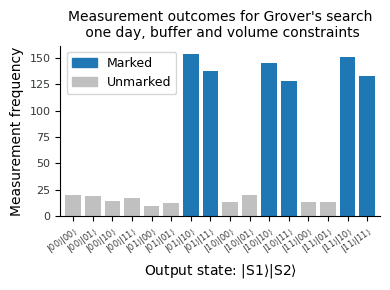

In [22]:
fig, ax = plt.subplots(figsize=(4,3)) # Small figure so that it looks ok in the two column format
selected_counts = {}
defaultcolor = 'silver'
markedcolor = '#1f77b4'
markedstates = ['0110','0111','1010','1011','1110','1111']

# Go through the measurement results to plot with bars in different colors depending on if the key is in 'markedstates'
barcolors = []
for key, value in sortdict:
    if key in markedstates:
        barcolors.append(markedcolor)
    else:
        barcolors.append(defaultcolor)
    newkey = "$|" + key[0] + key[1] + "\\left\\rangle |" #  〉
    newkey += key[2] + key[3] + '\\right\\rangle$'
    selected_counts[newkey] = value


# For the legend
custom_lines = [plt.Rectangle((0,0),1,1, color=markedcolor),
                plt.Rectangle((0,0),1,1, color=defaultcolor)]
plt.legend(custom_lines, ["Marked", "Unmarked"], loc='upper left', fontsize=9)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.margins(x=0.016)

ax.bar(range(len(selected_counts)), list(selected_counts.values()), tick_label=list(selected_counts.keys()), color=barcolors)
plt.setp(ax.get_xticklabels(), rotation=35, ha="right", rotation_mode="anchor", size=6, color='#343837' )
plt.yticks(range(0,max(selected_counts.values())+1,25), color='#343837', size=8)
plt.xlabel("Output state: |S1$\\rangle$|S2$\\rangle$",size=10)
plt.ylabel("Measurement frequency",size=10)
plt.title("Measurement outcomes for Grover's search\n one day, buffer and volume constraints", size = 10)
fig.tight_layout()
plt.show()

Uncomment to save the figure

In [23]:
# filename = "QISS_Grovers_1day_no_cost.eps"
# fig.savefig(filename, format='eps')